In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
my_df = pd.read_csv(r'C:\Users\Swayam Dutta\Desktop\Sentiment Analysis\clean_tweet.csv',encoding='latin1',index_col=0)
my_df[my_df.target == 4].head()

,text,target
800000,love guys the best,4
800001,im meeting up with one of my besties tonight c...,4
800002,thanks for the twitter add sunisa got to meet ...,4
800003,being sick can be really cheap when it hurts t...,4
800004,he has that effect on everyone,4


In [2]:
np.sum(my_df.isnull().any(axis=1))

3959

In [3]:
my_df.isnull().any(axis=0)

text       True
target    False
dtype: bool

In [4]:
my_df.dropna(inplace=True)

In [6]:
my_df.reset_index(drop=True,inplace=True)

In [7]:
x = my_df.text
y = my_df.target
from sklearn.cross_validation import train_test_split
SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [11]:
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

In [14]:
print("Train set has total %d entries with %.2f%% negative, %.2f%% positive"%(len(x_train),                                                                     
(len(x_train[y_train == 0]) / (len(x_train)*1.))*100,
(len(x_train[y_train == 4]) / (len(x_train)*1.))*100))

Train set has total 1564120 entries with 50.02% negative, 49.98% positive


In [16]:
print("Validation set has total %d entries with %.2f%% negative, %.2f%% positive"%(len(x_validation),                                    
(len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100,                                                                       
(len(x_validation[y_validation == 4]) / (len(x_validation)*1.))*100))

Validation set has total 15960 entries with 49.45% negative, 50.55% positive


In [18]:
print("Test set has total %d entries with %.2f%% negative, %.2f%% positive"%(len(x_test), 
(len(x_test[y_test == 0]) / (len(x_test)*1.))*100,
(len(x_test[y_test == 4]) / (len(x_test)*1.))*100))

Test set has total 15961 entries with 49.68% negative, 50.32% positive


In [19]:
from textblob import TextBlob
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

In [21]:
tbresult = [TextBlob(str(i)).sentiment.polarity for i in x_validation]
tbpred = [0 if n < 0 else 4 for n in tbresult]

In [22]:
conmat = np.array(confusion_matrix(y_validation, tbpred, labels=[4,0]))

In [23]:
confusion = pd.DataFrame(conmat, index=['positive', 'negative'],columns=['predicted_positive','predicted_negative'])

In [25]:
print("Accuracy Score: %.2f%%"%(accuracy_score(y_validation, tbpred)*100))
print("-"*80)
print("Confusion Matrix\n")
print(confusion)
print("-"*80)
print("Classification Report\n")
print(classification_report(y_validation, tbpred))

Accuracy Score: 61.84%
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_positive  predicted_negative
positive                7282                 785
negative                5306                2587
--------------------------------------------------------------------------------
Classification Report

             precision    recall  f1-score   support

          0       0.77      0.33      0.46      7893
          4       0.58      0.90      0.71      8067

avg / total       0.67      0.62      0.58     15960



In [26]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time

In [29]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print("null accuracy: %.2f%%"%(null_accuracy*100))
    print("accuracy score: %.2f%%"%(accuracy*100))
    if accuracy > null_accuracy:
        print("model is %.2f%% more accurate than null accuracy"%((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print("model has the same accuracy with the null accuracy")
    else:
        print("model is %.2f%% less accurate than null accuracy"%((null_accuracy-accuracy)*100))
    print("train and test time: %.2fs"%(train_test_time))
    print("-"*80)
    return accuracy, train_test_time

In [30]:
cvec = CountVectorizer()
lr = LogisticRegression()
n_features = np.arange(10000,100001,10000)

In [31]:
def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print(classifier)
    print("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print("Validation result for %d features"%(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy,tt_time))
    return result

In [32]:
csv = r'C:\Users\Swayam Dutta\Desktop\Sentiment Analysis\term_freq_df.csv'
term_freq_df = pd.read_csv(csv,index_col=0)
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]


,negative,positive,total
to,313162,252567,565729
the,257836,265998,523834
my,190775,125955,316730
it,157448,147786,305234
and,153958,149642,303600
you,103844,198245,302089
not,194724,86861,281585
is,133432,111191,244623
in,115542,101160,216702
for,98999,117369,216368


In [33]:
my_stop_words = frozenset(list(term_freq_df.sort_values(by='total', ascending=False).iloc[:10].index))

In [34]:
print("RESULT FOR UNIGRAM WITHOUT STOP WORDS\n")
feature_result_wosw = nfeature_accuracy_checker(stop_words='english')
print("RESULT FOR UNIGRAM WITH STOP WORDS\n")
feature_result_ug = nfeature_accuracy_checker()
print("RESULT FOR UNIGRAM WITHOUT CUSTOM STOP WORDS (Top 10 frequent words)\n")
feature_result_wocsw = nfeature_accuracy_checker(stop_words=my_stop_words)

RESULT FOR UNIGRAM WITHOUT STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 10000 features
null accuracy: 50.55%
accuracy score: 77.34%
model is 26.80% more accurate than null accuracy
train and test time: 139.27s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 50.55%
accuracy score: 77.66%
model is 27.11% more accurate than null accuracy
train and test time: 148.94s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 50.55%
accuracy score: 77.78%
model is 27.24% more accurate than null accuracy
train and test time: 163.59s
----------------------------------------------------

In [35]:
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug_wocsw = pd.DataFrame(feature_result_wocsw,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug_wosw = pd.DataFrame(feature_result_wosw,columns=['nfeatures','validation_accuracy','train_test_time'])

In [36]:
plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='with stop words')
plt.plot(nfeatures_plot_ug_wocsw.nfeatures, nfeatures_plot_ug_wocsw.validation_accuracy,label='without custom stop words')
plt.plot(nfeatures_plot_ug_wosw.nfeatures, nfeatures_plot_ug_wosw.validation_accuracy,label='without stop words')
plt.title("Without stop words VS With stop words (Unigram): Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

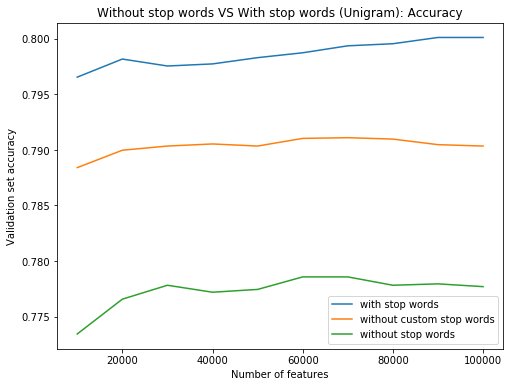

In [37]:
plt.show()

In [ ]:
print("RESULT FOR BIGRAM WITH STOP WORDS\n")
feature_result_bg = nfeature_accuracy_checker(ngram_range=(1, 2))
print("RESULT FOR TRIGRAM WITH STOP WORDS\n")
feature_result_tg = nfeature_accuracy_checker(ngram_range=(1, 3))

RESULT FOR BIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 10000 features
null accuracy: 50.55%
accuracy score: 80.58%
model is 30.04% more accurate than null accuracy
train and test time: 371.89s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 50.55%
accuracy score: 81.39%
model is 30.85% more accurate than null accuracy
train and test time: 432.76s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 50.55%
accuracy score: 81.79%
model is 31.25% more accurate than null accuracy
train and test time: 352.41s
--------------------------------------------------------